In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6.75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
stock = 'HUBS'
source = 'yahoo'
start = datetime(2020,1,1)
end = datetime.today()
df = web.DataReader(stock, source, start, end)
df['Median'] = (df['High'] - df['Low']) * 0.5 + df['Low']
for col in df.columns:
    df[col] = np.round(df[col], 2)
ts = df['Median']

In [2]:
def test_stationarity(ts, window=12, cutoff=0.05):
    global rolmean, rolstd
    rolmean = ts.rolling(window).mean()
    rolstd = ts.rolling(window).std()
    plt.plot(ts, label='Timeseries')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Standard Deviation')
    plt.legend(loc="best")
    plt.show(block=False)
    adft = adfuller(ts, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'P-Values', '# Lags', '# Observations'])
    for key, value in adft[4].items():
        output['critical value (%s)' % key] = value
    print(output)
    print("\n")
    if adft[1] > cutoff:
        print("Likely non-stationary.")
    else:
        print("Likely stationary.")

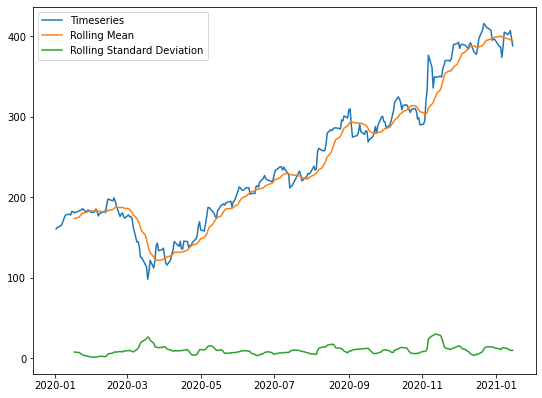

Test Statistics          -0.090563
P-Values                  0.950370
# Lags                    2.000000
# Observations          260.000000
critical value (1%)      -3.455754
critical value (5%)      -2.872721
critical value (10%)     -2.572728
dtype: float64


Likely non-stationary.


In [3]:
test_stationarity(ts)

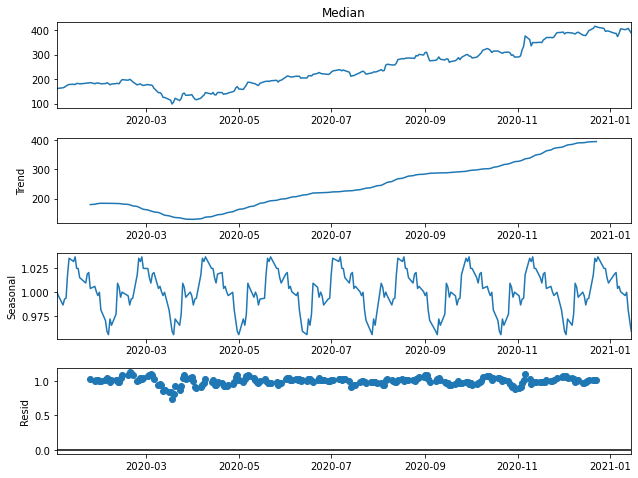

In [4]:
sd = seasonal_decompose(ts, model='multiplicative', period=30)
sd.plot()
plt.show()

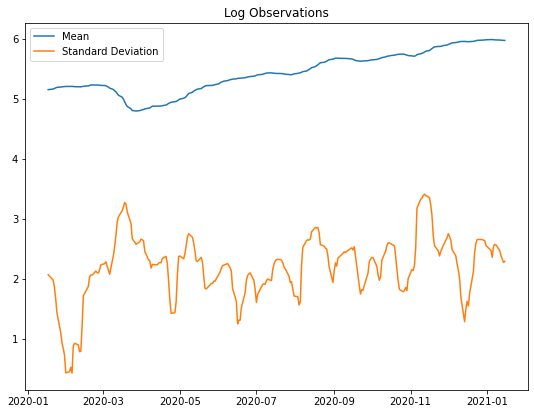

In [5]:
meanlog = np.log(rolmean)
stdlog = np.log(rolstd)
plt.plot(meanlog, label='Mean')
plt.plot(stdlog, label='Standard Deviation')
plt.legend()
plt.title("Log Observations")
plt.show()

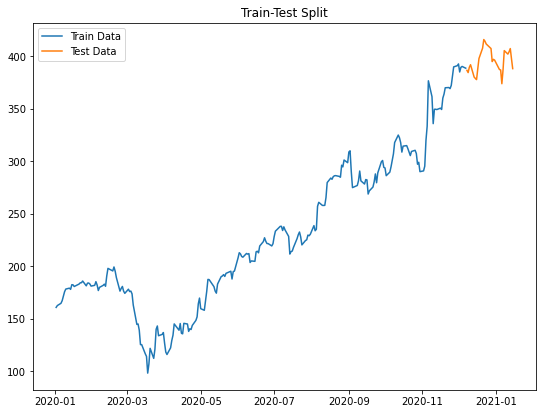

In [6]:
split = int(len(ts) * 0.9)
train, test = ts[:split], ts[split:]
plt.plot(train, label='Train Data')
plt.plot(test, label='Test Data')
plt.legend(loc="best")
plt.title("Train-Test Split")
plt.show()

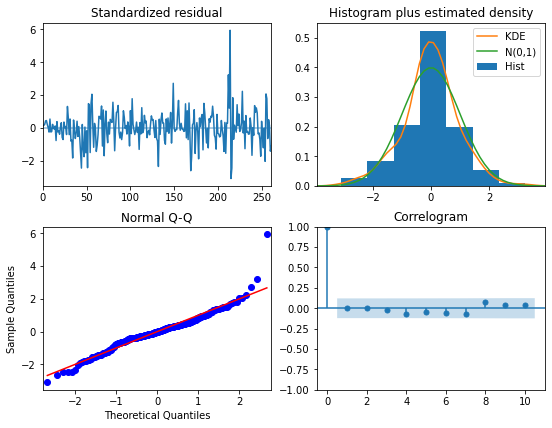

In [7]:
m_aa = auto_arima(ts)
m_aa.plot_diagnostics()
plt.subplots_adjust(hspace=0.25)
plt.show()

In [8]:
def evaluate_arima_model(X, arima_order):
    split = int(len(X) * 0.66)
    train, test = X[:split], X[split:]
    history = [X for X in train]
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_models(dataset, pvals, dvals, qvals):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in pvals:
        for d in dvals:
            for q in qvals:
                order = (p,d,q)
            try:
                rmse = evaluate_arima_model(dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                print("ARIMA%s RMSE=%.3f" % (order, rmse))
            except:
                continue
    print("Best ARIMA%s RMSE=%.3f" % (best_cfg, best_score))

In [9]:
p_values = [0,1,2,4,6,8,10]
d_values = range(0,3)
q_values = range(0,3)
evaluate_models(ts, p_values, d_values, q_values)

ARIMA(0, 1, 2) RMSE=9.233
ARIMA(0, 2, 2) RMSE=9.222
ARIMA(1, 2, 2) RMSE=9.293
ARIMA(2, 1, 2) RMSE=9.404
ARIMA(4, 1, 2) RMSE=9.482
ARIMA(8, 1, 2) RMSE=9.369
ARIMA(10, 1, 2) RMSE=9.604
Best ARIMA(0, 2, 2) RMSE=9.222


In [11]:
test_len = len(test)
date_list = []
for d in range(0, test_len):
    date_list.append(end + timedelta(days=d))
date_list = pd.Series(date_list)
date_list.index = date_list.values

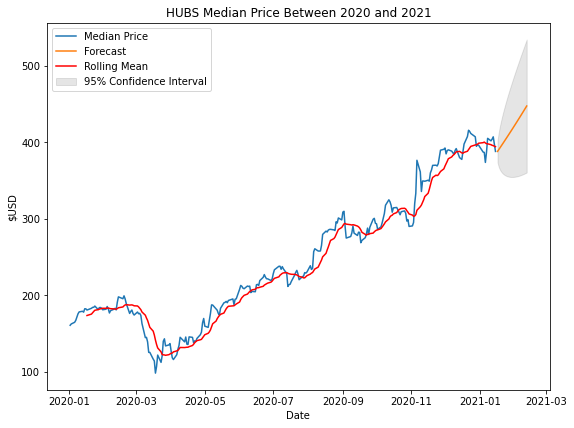

In [15]:
model = ARIMA(train, order=(0,2,2)).fit(disp=-1)

fc, se, conf = model.forecast(test_len, alpha=0.05)
fc = pd.Series(fc, index=date_list.index)
fc_diff = ts[-1] - fc[0]
fc = fc + fc_diff
lower = conf[:,0] + fc_diff
upper = conf[:,1] + fc_diff
plt.plot(ts, label='Median Price')
plt.plot(fc, label='Forecast')
plt.plot(rolmean, label='Rolling Mean', color='red')
plt.fill_between(date_list.index, lower, upper, color='k', alpha=0.1, label='95% Confidence Interval')
plt.title("%s Median Price Between %s and %s" % (stock, str(start.year), str(end.year)))
plt.xlabel("Date")
plt.ylabel("$USD")
plt.legend(loc="upper left")
plt.show()